# Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial - Inteligencia Artificial para Juegos (Game IA) - Sesión 8 - Tarea - Solución

<img src='https://www.danielsaromo.xyz/assets/img/logo-pucp.png' width=200px>


Dr. Edwin Villanueva, Ing. Daniel Saromo

<font color='orange'>Entorno de `MountainCar-v0` con agente aleatorio y aprendizaje con DDQN. **NO renderizable en Google Colaboratory!**.</font>

Para poder visualizar gráficamente el agente entrenado, se debe abrir un entorno de GitPod, al igual que en la sesión del entorno Pacman UCB.

Seguir las instrucciones mostradas en: https://github.com/DanielSaromo/Pacman_UCB_Behavioral_Cloning

## Configuración del entorno colab

In [1]:
#!pip install gym==0.22

In [2]:
#!pip install tensorflow==2.15.0

## Aprendizaje por refuerzo con Double Deep Q-networks - Entorno `MountainCar-v0`

Esta es una implementacion de un agente Double Deep Q-learning que aprende a mover el carrito para que alcance la bandera amarilla en el entorno `MountainCar-v0` de OpenAI Gym. Adaptado de  https://github.com/keon/deep-q-learning.

Es necesario tener instalado: gym, tensorflow y keras. En colab, están preinstalados.

Descripción detallada del entorno: https://github.com/openai/gym/wiki/MountainCar-v0

Completar con su código los campos requeridos y subir su notebook solucionado a la plataforma PAIDEIA. El formato del nombre del notebook es: `Desafio8_APELLIDOPATERNO_NOMBRE.ipynb`.

Es responsabilidad del alumno verificar que el archivo que subió es el correcto. Respetar los lineamientos de la entrega de archivo, ya que influirá en su calificación. La fecha límite de entrega del presente desafío se encuentra en PAIDEIA.

### Clase <b>DDQNAgent</b>

Esta es la clase que implementa el agente Double Deep Q-lerrning. Es una implementacion general, pudiendo ser usado en diferentes entornos de gym u otros. El constructor recibe las dimensiones del estado y la dimesion del vector de acciones posibles

In [1]:
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2 # pueden usar regularización

class DDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size      # tamaño de un estado (numero de atributos que representan un estado)
        self.action_size = action_size    # tamaño del vector de acciones
        self.memory = deque(maxlen=10000)  # define la memoria del agente (10000 registros como maximo)
        self.gamma = 0.98                  # discount rate
        self.learning_rate = 0.0005          # tasa de aprendizaje

        self.epsilon = 1.0               # factor de exploration inicial
        self.epsilon_min = 0.01          # factor de exploration minimo
        self.epsilon_decay = 0.997       # factor de decaimiento del factor de exploracion
        self.model = self._build_model() # construye el modelo neuronal a entrenar

        # construye un 2do modelo neuronal (target_model) para ayudar a estimar el target del 1er modelo (model)
        self.target_model = self._build_model()
        self.update_target_model()  # actualiza el target_model copiando los pesos de model


    def _build_model(self):
        # Define y compila un modelo de red neuronal de 3 capas: state_size entradas X 32 neuronas X 32 neuronas x action_size neuronas de salida
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=AdamW(learning_rate=self.learning_rate))
        return model

    # Metodo para copiar los pesos de model a target_model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # metodo para guardar una transicion del agente (experiencia): (estado, accion, reward resultante, nuevo estado, done)
    # done es un flag que indica que el entorno cayo en un estado terminal
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # retorna una accion.
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:  # retorna una accion aleatoria con probabilidad self.epsilon
            return random.randrange(self.action_size)
        action_values = self.model.predict(state, verbose=0) # obtiene los q valores predichos por el modelo para cada accion
        return np.argmax(action_values[0])  # retorna la accion con el maximo q-valor predicho

    # metodo para actualizar los pesos de model con una muestra (minibatch) de la memoria de experiencias de tamaño batch_size
    def replay(self, batch_size):
      if len(self.memory) < batch_size:
          return  # No se ejecuta si no hay suficientes experiencias almacenadas

      minibatch = random.sample(self.memory, batch_size)

      # Convertimos el minibatch en arrays para usar batch processing
      states = np.vstack([x[0] for x in minibatch])
      actions = np.array([x[1] for x in minibatch])
      rewards = np.array([x[2] for x in minibatch])
      next_states = np.vstack([x[3] for x in minibatch])
      dones = np.array([x[4] for x in minibatch])

      # Predicción de los Q-valores actuales para los estados en el minibatch
      target_q_values = self.model.predict(states, verbose=0)

      # Predicción de las mejores acciones con el modelo actual (DDQN)
      next_actions = np.argmax(self.model.predict(next_states, verbose=0), axis=1)

      # Predicción de los Q-valores del modelo objetivo para los próximos estados
      target_q_values_next = self.target_model.predict(next_states, verbose=0)

      # Aplicación de la actualización de Double DQN
      batch_indices = np.arange(batch_size)
      target_q_values[batch_indices, actions] = rewards + self.gamma * target_q_values_next[batch_indices, next_actions] * (1 - dones)

      # Ajuste del modelo en batch
      self.model.fit(states, target_q_values, batch_size=batch_size, verbose=0, epochs=1)

      # Reducción de epsilon
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

### Familiarización con el entorno

[`MountainCar-v0`](https://github.com/openai/gym/wiki/MountainCar-v0)

In [28]:
env = gym.make('MountainCar-v0')   # carga el modelo MountainCar de gym
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DDQNAgent(state_size, action_size)  # instancia el agente DDQN
state_size, action_size

(2, 3)

In [54]:
state = env.reset()     # resetea el entorno
print("Vanilla State: ", state)
state

Vanilla State:  [-0.58298784  0.        ]


array([-0.58298784,  0.        ], dtype=float32)

In [55]:
score = 0
action = agent.get_action(state)   # obtiene una accion del agente
action

2

In [56]:
# la linea siguiente cambia al pasar de gym a gymnasium. usaremos gym.
next_state, reward, done, extraInfo = env.step(action)  # ejecuta action en el entorno y obtiene: nuevo estado, reward y flag done (si es estado terminal)
print("Vanilla New State: ", next_state)
next_state, reward, done, extraInfo

Vanilla New State:  [-0.58154476  0.00144307]


(array([-0.58154476,  0.00144307], dtype=float32), -1.0, False, {})

### Definiendo la función de recompensa

¿Cuál es el dominio de `state[0]`?:

- https://www.gymlibrary.dev/environments/classic_control/mountain_car/
- https://github.com/openai/gym/wiki/MountainCar-v0

¿Cómo definimos la función de reward? Podríamos hacerlo de [esta manera](https://www.wolframalpha.com/input?i=plot+piecewise+%5B%7B+%7B-20*%28x%2B0.5%29%5E2%2B0.5%2C+-1.2%3C%3Dx%3C-0.6%7D+%2C+%7B4000*%28x%2B0.5%29%5E3-8%2C+-0.6%3C%3Dx%3C-0.4%7D+%2C+%7B7*%28x%2B0.5%29%5E2%2B5*abs%28x%2B0.5%29%2B2.5%2C+-0.4%3C%3Dx%3C0.25%7D%2C+%7B5*%28x%29%5E3%2B10*x%2B10%2C+0.25%3C%3Dx%3C%3D0.6%7D%7D%5D&lang=es).

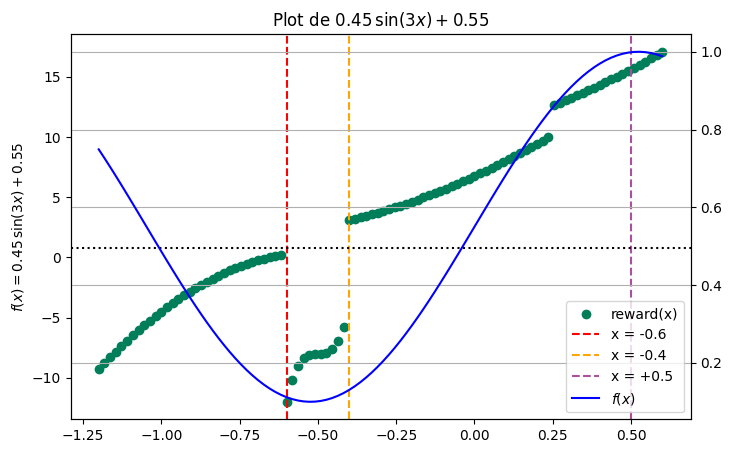

Reward por defecto del entorno: `reward(x)=-1`.

In [2]:
def get_reward(state):
    x=state[0]
    v=state[1]
    if x >= 0.5:
      print("Car has reached the goal 😁")
      #No está permitido editar las anteriores líneas de código de esta función!
      return 100
    if -1.2 <= x < -0.6:
        return -20 * (x + 0.5)**2 + 0.5
    elif -0.6 <= x < -0.4:
        return 4000 * (x + 0.5)**3 - 8
    elif -0.4 <= x < 0.25:
        return 7 * (x + 0.5)**2 + 5 * abs(x + 0.5) + 2.5
    elif 0.25 <= x <= 0.6:
        return 5 * (x)**3 + 10 * x + 10
    else:
        return -1

In [58]:
next_state[0]

-0.58154476

¿Cómo agregaríamos al reward, una bonificación extra relacionada a la máxima posición horizontal alcanzada?

### Ejecutando el agente en el entorno MountainCar



In [59]:
done = False
batch_size = 128    # tamaño del batch con el que se re-entrena el modelo neuronal
EPISODES = 150      # numero de episodios # OJO CON ESTE VALOR

env = gym.make('MountainCar-v0')   # carga el modelo MountainCar de gym
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DDQNAgent(state_size, action_size)  # instancia el agente double deep q-learning

score_list = []     # lista para guardar la evolucion del score
epsilon_list = []
max_pos_reached_list = []

for e in range(1,EPISODES+1):   # por cada episodio
    state = env.reset()     # resetea el entorno
    state = np.reshape(state, [1, state_size]) # se hace un reshape para que la red neuronal entienda el state
    score = 0
    score_puro = 0

    max_pos_reached = -9999
    for step in range(1500):   # prueba el agente hasta 1500 pasos, sale de este loop cuando se cae en estado terminal
        #env.render()  # renderiza el entorno (por ahora no activarlo, porque de forma nativa, el renderizado no funciona en colab)
        action = agent.get_action(state)   # obtiene una accion del agente
        next_state, reward, done, _ = env.step(action)  # ejecuta action en el entorno y obtiene: nuevo estado, reward y flag done (si es estado terminal)

        reward = get_reward(next_state)
        max_pos_reached=max(max_pos_reached, next_state[0])
        reward += max_pos_reached*10

        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done) # almacena esta experiencia en la memoria del agente
        state = next_state   # actualiza el estado actual al nuevo estado

        score += reward
        score_puro += (reward-max_pos_reached*10)

        if len(agent.memory) > batch_size:  # si hay suficiente experiencias en memoria del agente -> ajusta su modelo neuronal
            agent.replay(batch_size)

        if done:  # si es estado terminal, imprime resultados del trial. El escore del trial es el numero de pasos que logro ejecutar el agente
            print("episode: {}/{}, score: {:.4}, e: {:.2}".format(str(e).zfill(3), EPISODES, score, agent.epsilon))
            print("max pos reached: {:.4}".format(max_pos_reached))
            print("score_puro:", score_puro)
            #score += (max_pos_reached*200)+400
            #print("episode: {}/{}, post_score: {}, e: {:.2}".format(e, EPISODES, score, agent_conEstimacion.epsilon))
            max_pos_reached_list.append(max_pos_reached)
            break

    agent.update_target_model()  # actualiza el target_model al final de cada trial
    score_list.append(score)
    epsilon_list.append(agent.epsilon)

env.close()

episode: 001/150, score: -1.79e+03, e: 0.81
max pos reached: -0.3607
score_puro: -968.8254609750978
episode: 002/150, score: -2.233e+03, e: 0.44
max pos reached: -0.3952
score_puro: -1384.0893607656467
episode: 003/150, score: -1.24e+03, e: 0.24
max pos reached: -0.2847
score_puro: -613.9566759368369
episode: 004/150, score: -1.771e+03, e: 0.13
max pos reached: -0.5107
score_puro: -749.168043572808
episode: 005/150, score: -1.718e+03, e: 0.073
max pos reached: -0.5499
score_puro: -590.371631433931
episode: 006/150, score: -1.632e+03, e: 0.04
max pos reached: -0.4299
score_puro: -770.835437135753
episode: 007/150, score: -1.697e+03, e: 0.022
max pos reached: -0.4583
score_puro: -775.1029890342136
episode: 008/150, score: -1.618e+03, e: 0.012
max pos reached: -0.4142
score_puro: -790.1227709992335
episode: 009/150, score: -1.414e+03, e: 0.01
max pos reached: -0.5838
score_puro: -246.12307119565247
episode: 010/150, score: -1.62e+03, e: 0.01
max pos reached: -0.4164
score_puro: -786.78416

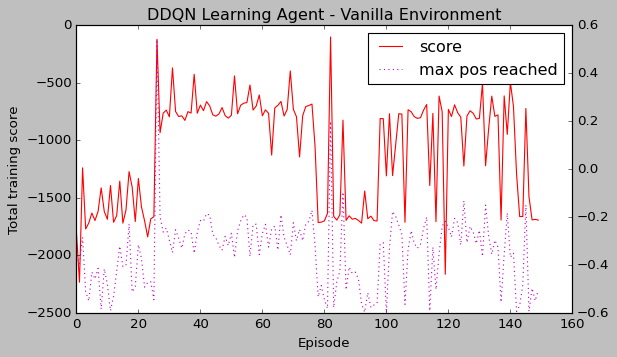

In [61]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('classic')

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.set_title('DDQN Learning Agent - Vanilla Environment')
ax.set_xlabel('Episode')
ax.set_ylabel('Total training score')
ax.plot(score_list,'r-', label='score')
ax2 = ax.twinx()
ax2.plot(max_pos_reached_list,'m:', label='max pos reached')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()

### Análisis de Resultados. El agente llega a cumplir su objetivo, pero pocas veces


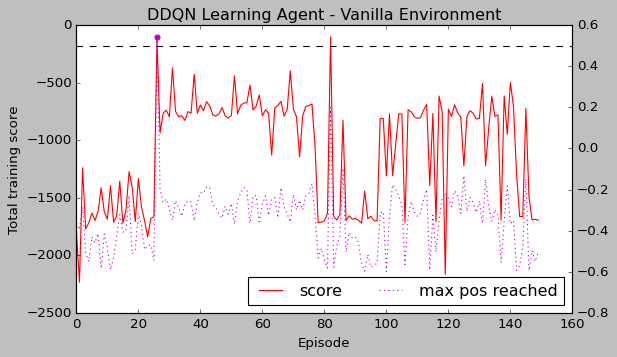

In [62]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('classic')

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.set_title('DDQN Learning Agent - Vanilla Environment')
ax.set_xlabel('Episode')
ax.set_ylabel('Total training score')
ax.plot(score_list,'r-', label='score')
ax2 = ax.twinx()
ax2.plot(max_pos_reached_list,'m:', label='max pos reached')
ax2.axhline(0.5, linestyle = '--', color='k', lw=1)

max_pos_reached_list_onlySobreRedBar = [x for x in max_pos_reached_list if x >= 0.5]

t1 = [i for i, x in enumerate(max_pos_reached_list) if x >= 0.5]

ax2.scatter(t1, max_pos_reached_list_onlySobreRedBar, color='m')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="lower right", ncols=2)
plt.show()

¿Cómo podemos mejorar el desempeño del agente, usando la teoría vista en clase?

### Veamos!

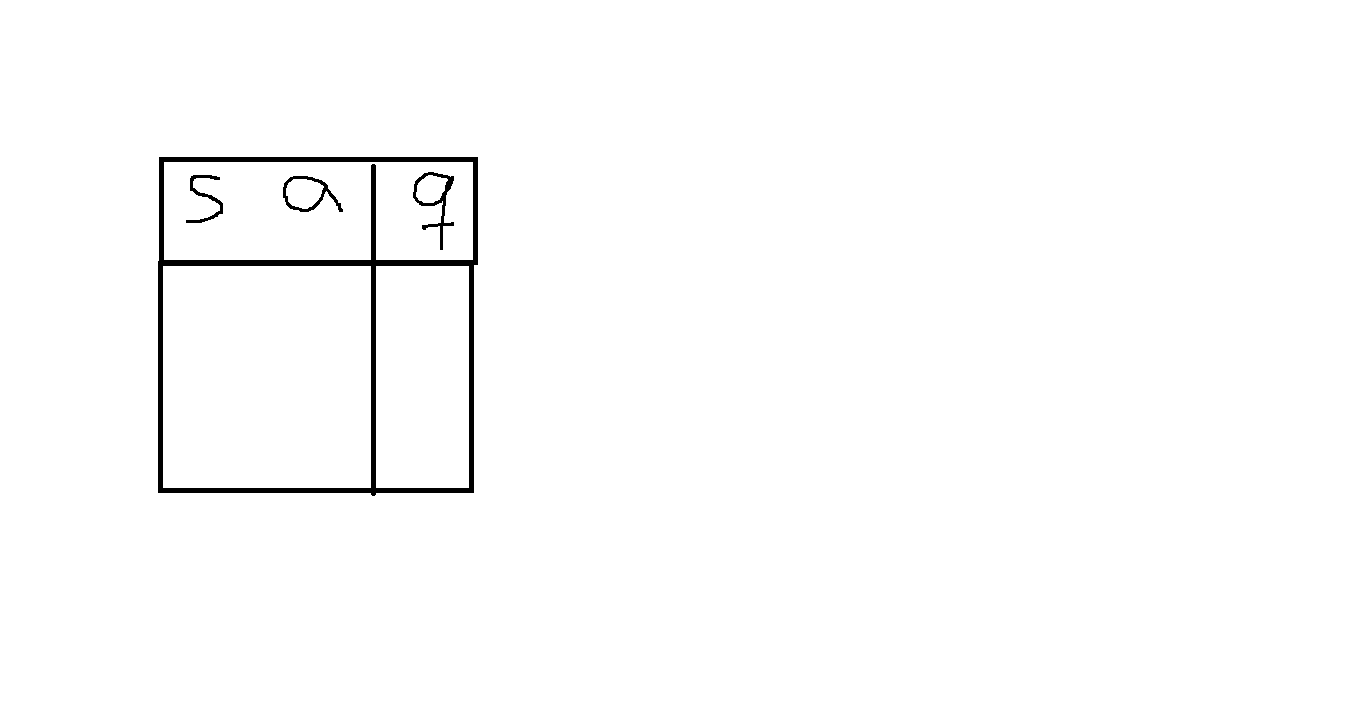

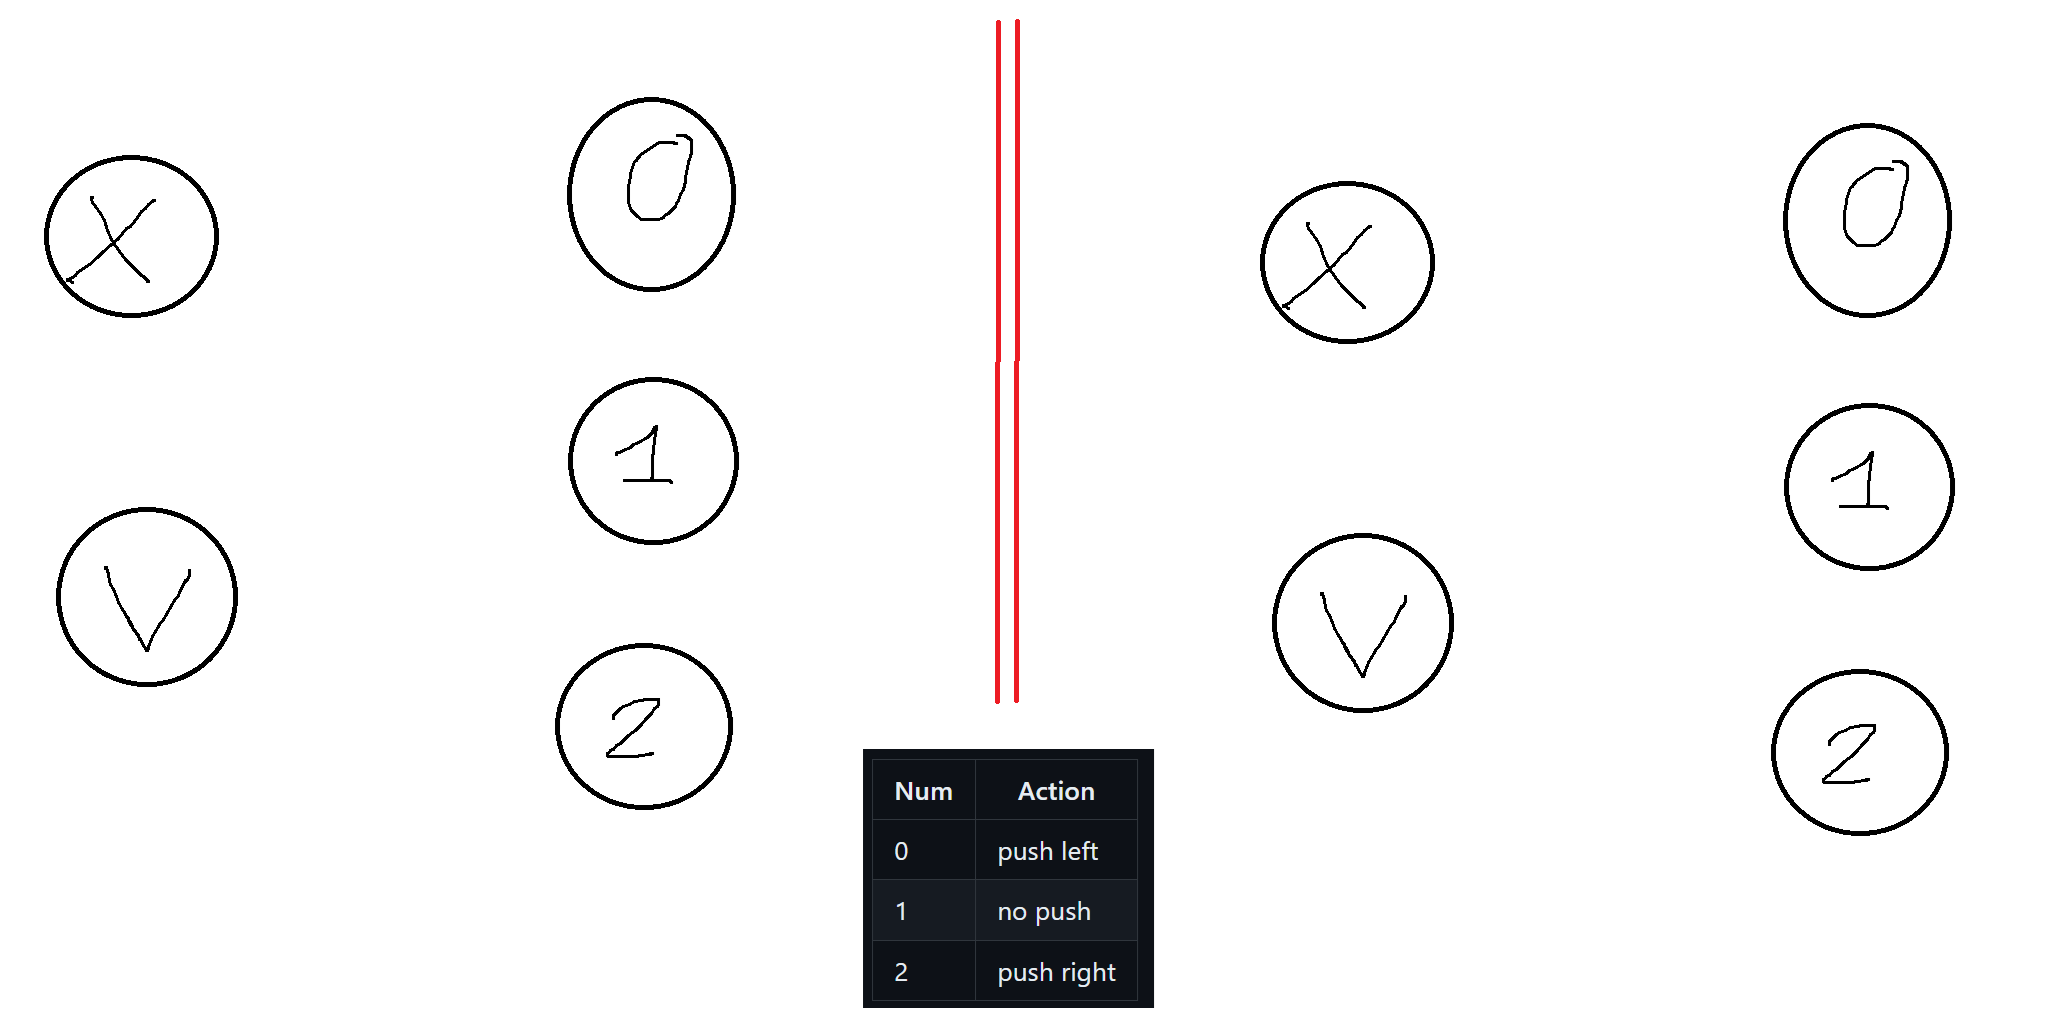

Llegar de A a C es más difícil que llegar de A a B y luego de B a C.

Nota importante: Por qué ***NO*** podemos dar directamente información de la acción, en los estados augmentados?

### Ejecutando el agente en el entorno MountainCar - Entorno augmentado con estimador de estados



In [3]:
class EstimadorEstadosInternos():
    def __init__(self, initial_state):
        self.estado_t_menos_1 = initial_state
        self.estado_t_menos_2 = initial_state

    def calculaEstadosInternos(self, nuevo_estado):
        estado_augmentado = np.array([
                nuevo_estado[0],
                nuevo_estado[1],
                nuevo_estado[1] - self.estado_t_menos_1[1], # "derivador" de la velocidad
                nuevo_estado[1]-2*self.estado_t_menos_1[1]+self.estado_t_menos_2[1], # "2do-derivador" de la velocidad
                self.estado_t_menos_1[1],
                self.estado_t_menos_2[1], # velocidades antiguas
                np.sin(nuevo_estado[0]),
                np.cos(nuevo_estado[0]),
              ])
        self.estado_t_menos_2 = self.estado_t_menos_1
        self.estado_t_menos_1 = nuevo_estado
        return estado_augmentado

In [64]:
next_state.shape

(1, 2)

In [65]:
done = False
batch_size = 128    # tamaño del batch con el que se re-entrena el modelo neuronal
EPISODES = 150    # numero de episodios # OJO CON ESTE VALOR

env = gym.make('MountainCar-v0')   # carga el modelo MountainCar de gym
state_size = env.observation_space.shape[0] + 6 # voy a estimar 6 estados extra
action_size = env.action_space.n
agent_conEstimacion = DDQNAgent(state_size, action_size)  # instancia el agente double deep q-learning

score_list_conEstimacion = []     # lista para guardar la evolucion del score
epsilon_list_conEstimacion = []
max_pos_reached_list_conEstimacion = []

for e in range(1,EPISODES+1):   # por cada episodio
    state = env.reset()     # resetea el entorno

    estimador = EstimadorEstadosInternos(state)
    state = estimador.calculaEstadosInternos(state)

    state = np.reshape(state, [1, state_size]) # se hace un reshape para que la red neuronal entienda el state
    score = 0
    score_puro = 0

    max_pos_reached_conEstimacion = -9999
    for step in range(1500):   # prueba el agente hasta 1500 pasos, sale de este loop cuando se cae en estado terminal
        #env.render()  # renderiza el entorno (por ahora no activarlo, porque de forma nativa, el renderizado no funciona en colab)
        action = agent_conEstimacion.get_action(state)   # obtiene una accion del agente
        next_state, reward, done, _ = env.step(action)  # ejecuta action en el entorno y obtiene: nuevo estado, reward y flag done (si es estado terminal)

        reward = get_reward(next_state)
        max_pos_reached_conEstimacion=max(max_pos_reached_conEstimacion, next_state[0]) # la posición es el primer elemento de next_state
        reward += max_pos_reached_conEstimacion*10

        next_state = estimador.calculaEstadosInternos(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        agent_conEstimacion.remember(state, action, reward, next_state, done) # almacena esta experiencia en la memoria del agente
        state = next_state   # actualiza el estado actual al nuevo estado

        score += reward
        score_puro += (reward-max_pos_reached_conEstimacion*10)

        if len(agent_conEstimacion.memory) > batch_size:  # si hay suficiente experiencias en memoria del agente -> ajusta su modelo neuronal
            agent_conEstimacion.replay(batch_size)

        if done:  # si es estado terminal, imprime resultados del trial. El escore del trial es el numero de pasos que logro ejecutar el agente
            print("episode: {}/{}, score: {:.4}, e: {:.2}".format(str(e).zfill(3), EPISODES, score, agent_conEstimacion.epsilon))
            print("max pos reached: {:.4}".format(max_pos_reached_conEstimacion))
            print("score_puro:", score_puro)
            #score += (max_pos_reached_conEstimacion*200)+400
            #print("episode: {}/{}, post_score: {}, e: {:.2}".format(e, EPISODES, score, agent_conEstimacion.epsilon))
            max_pos_reached_list_conEstimacion.append(max_pos_reached_conEstimacion)
            break

    agent_conEstimacion.update_target_model()  # actualiza el target_model al final de cada trial
    score_list_conEstimacion.append(score)
    epsilon_list_conEstimacion.append(agent_conEstimacion.epsilon)

env.close()

episode: 001/150, score: -2.019e+03, e: 0.81
max pos reached: -0.3005
score_puro: -1158.435280025436
episode: 002/150, score: -1.755e+03, e: 0.44
max pos reached: -0.3859
score_puro: -921.9849212829558
episode: 003/150, score: -2.509e+03, e: 0.24
max pos reached: -0.4062
score_puro: -1696.6628918919516
episode: 004/150, score: -1.146e+03, e: 0.13
max pos reached: -0.3113
score_puro: -472.6952427409441
episode: 005/150, score: -804.3, e: 0.073
max pos reached: -0.2553
score_puro: -240.17525775118733
episode: 006/150, score: -740.3, e: 0.04
max pos reached: -0.162
score_puro: -269.50830476818714
episode: 007/150, score: -665.4, e: 0.022
max pos reached: -0.1552
score_puro: -253.77090090261112
episode: 008/150, score: -681.2, e: 0.012
max pos reached: -0.1515
score_puro: -242.0466372243362
episode: 009/150, score: -748.3, e: 0.01
max pos reached: -0.3292
score_puro: -55.50756199170463
episode: 010/150, score: -698.0, e: 0.01
max pos reached: -0.2179
score_puro: -203.85117769956372
episode

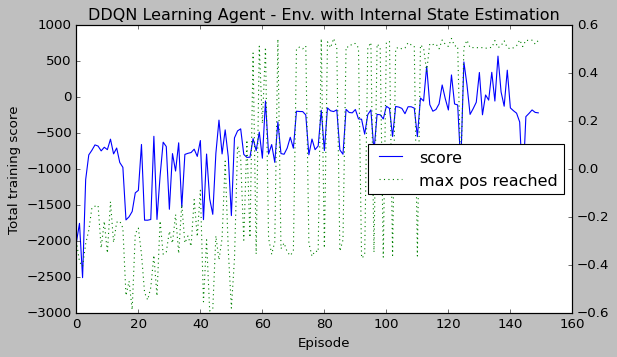

In [66]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('classic')

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.set_title('DDQN Learning Agent - Env. with Internal State Estimation')
ax.set_xlabel('Episode')
ax.set_ylabel('Total training score')
ax.plot(score_list_conEstimacion,'-', color='b', label='score')
ax2 = ax.twinx()
ax2.plot(max_pos_reached_list_conEstimacion,'g:', label='max pos reached')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()

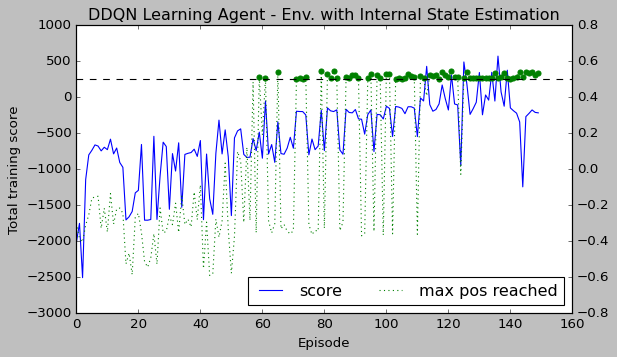

In [67]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('classic')

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.set_title('DDQN Learning Agent - Env. with Internal State Estimation')
ax.set_xlabel('Episode')
ax.set_ylabel('Total training score')
ax.plot(score_list_conEstimacion,'-', color='b', label='score')
ax2 = ax.twinx()
ax2.plot(max_pos_reached_list_conEstimacion,'g:', label='max pos reached')
ax2.axhline(0.5, linestyle = '--', color='k', lw=1)

max_pos_reached_list_conEstimacion_onlySobreRedBar = [x for x in max_pos_reached_list_conEstimacion if x >= 0.5]

t2 = [i for i, x in enumerate(max_pos_reached_list_conEstimacion) if x >= 0.5]

ax2.scatter(t2, max_pos_reached_list_conEstimacion_onlySobreRedBar, color='g')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="lower right", ncols=2)
plt.show()

### Comparación del desempeño en ambos entornos

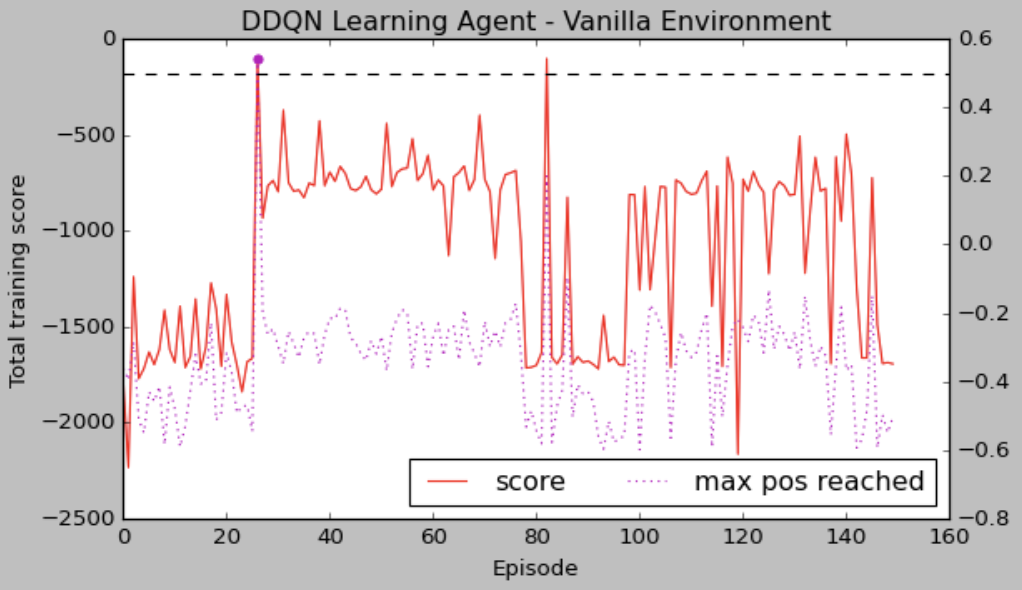

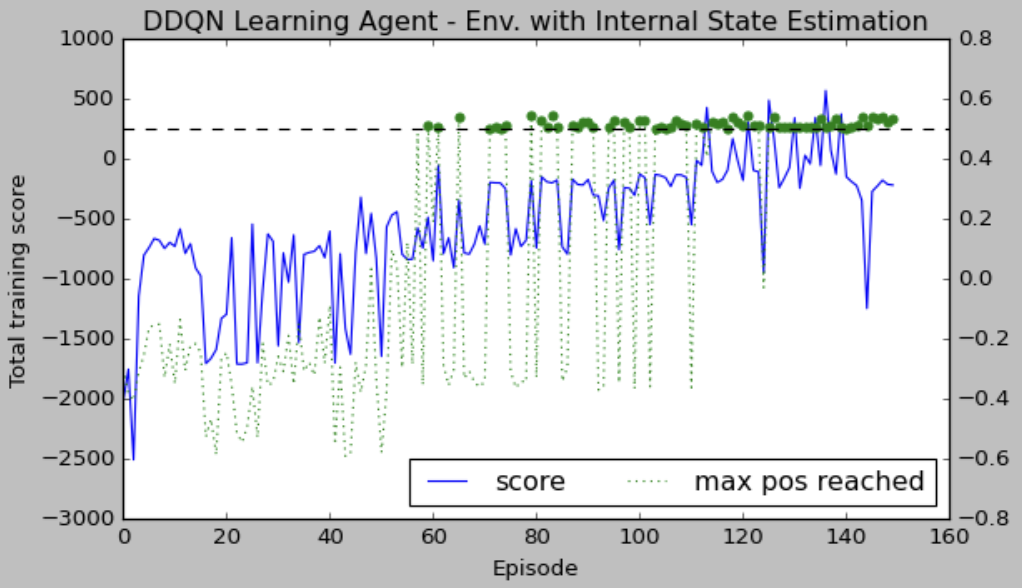

Enlace con la gráfica: https://raw.githubusercontent.com/DanielSaromo/Pacman_UCB_Behavioral_Cloning/master/ddqn_twoEnvs.pdf

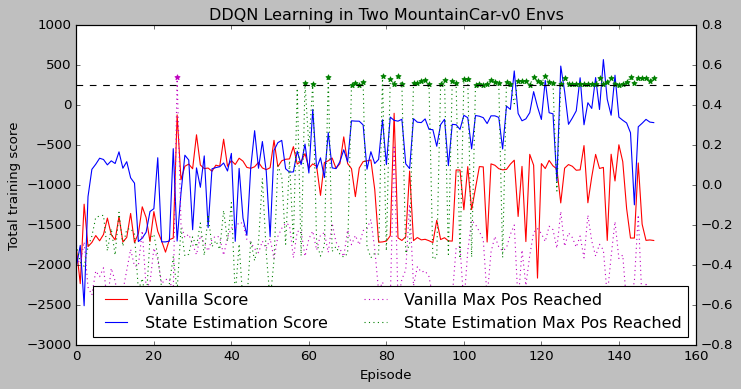

In [69]:
mpl.style.use('classic')

fig, ax = plt.subplots(figsize=(10, 5))

ax.set_title('DDQN Learning in Two MountainCar-v0 Envs')
ax.set_xlabel('Episode')
ax.set_ylabel('Total training score')

# Vanilla Environment
ax.plot(score_list, 'r-', label='Vanilla Score')
ax2 = ax.twinx()
ax2.plot(max_pos_reached_list, 'm:', label='Vanilla Max Pos Reached')

# Internal State Estimation Environment
ax.plot(score_list_conEstimacion, 'b-', label='State Estimation Score')
ax2.plot(max_pos_reached_list_conEstimacion, 'g:', label='State Estimation Max Pos Reached')

ax2.axhline(0.5, linestyle='--', color='k', lw=1)

max_pos_reached_list_onlySobreRedBar = [x for x in max_pos_reached_list if x >= 0.5]
t1 = [i for i, x in enumerate(max_pos_reached_list) if x >= 0.5]
ax2.scatter(t1, max_pos_reached_list_onlySobreRedBar, color='m', marker='*')

max_pos_reached_list_conEstimacion_onlySobreRedBar = [x for x in max_pos_reached_list_conEstimacion if x >= 0.5]
t2 = [i for i, x in enumerate(max_pos_reached_list_conEstimacion) if x >= 0.5]
ax2.scatter(t2, max_pos_reached_list_conEstimacion_onlySobreRedBar, color='g', marker='*')

# Legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="lower right", ncols=2)

plt.show()


### Grabando los agentes entrenados

No olvidar subir estos archivos a PAIDEIA, al hacer la entrega del presente desafío.

In [5]:
agent.model.save('../models/agent.keras')

In [68]:
agent_conEstimacion.model.save('../models/agent_v2.keras')

### Funcion para cargar desde un archivo externo a los agentes entrenados

In [6]:
from tensorflow.keras.saving import load_model

class DDQNAgent_reconstruido():
    def __init__(self, model_filename='agent.keras'):
        self.model = load_model(model_filename)
        self.state_size = self.model.input_shape[1]
        self.action_size = self.model.output_shape[1]

In [7]:
agent_onVanillaEnv = DDQNAgent_reconstruido('../models/agent.keras')
agent_onAugmentedEnv = DDQNAgent_reconstruido('../models/agent_v2.keras')

In [8]:
agent_onVanillaEnv.state_size, agent_onAugmentedEnv.state_size

(2, 8)

### Funcion para probar el agente entrenado  en el entorno MountainCar

play_MountainCar()  no realiza entrenamiento, solo actua en el ambiente de acuerdo a su modelo aprendido previamente


In [9]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [10]:
env = gym.make('MountainCar-v0')
env.reset()
env.reset()[:].shape

(2,)

In [11]:
agent_onVanillaEnv.model.predict(env.reset().reshape((1,-1))).shape[0]

1/1 [==============================] - 0s 30ms/step


1

In [12]:
def play_MountainCar(agentito, trials = 10):
    env = gym.make('MountainCar-v0')
    agentito.model.compile()
    scores = []
    state_size = agentito.state_size

    for trial in range(1,trials+1):
        game_memory = []
        state = env.reset()

        estimador = EstimadorEstadosInternos(state)
        state = estimador.calculaEstadosInternos(state) # esta línea permite verificar si el estimador funciona bien
        state = []

        score = 0
        score_puro = 0
        max_pos_reached = -9999
        num_ofExtraFeats = agentito.state_size - env.reset().shape[0]

        if trial == 1: print("Número de augmented features del entorno:", num_ofExtraFeats)

        for step in range(1500): # en cada trial ejecuta 1500 pasos
            env.render() # para visualizar en el entorno al agente entrenado previamente

            if len(state) == 0: # si es el primer movimiento  -> escoge una accion aleatoria
                action = random.randrange(0,env.action_space.n)
            else:
                action_values = agentito.model.predict(state.reshape(1, -1), verbose=0) # predice los q valores con la RN del agentito
                action = np.argmax(action_values[0]) # retorna la accion con el maximo q-valor predicho

            next_state, reward, done, _  = env.step(action) # corre el entorno un step ejecutando la accion inferida

            reward = get_reward(next_state)
            max_pos_reached=max(max_pos_reached, next_state[0])
            # al reward, agregaremos una bonificación extra relacionada a la mayor posición en x alcanzada
            reward += max_pos_reached*10

            if num_ofExtraFeats != 0:
                next_state = estimador.calculaEstadosInternos(next_state)

            next_state = np.reshape(next_state, [1, state_size])
            state = next_state # actualiza el estado actual al nuevo estado

            score += reward # el reward es lo ganado en este step. el score es el acumulado de rewards para el episodio

            # score_puro es el score, pero sin la bonficación extra relacionada a la máxima posición en x alcanzada
            score_puro += (reward-max_pos_reached*10)

            game_memory.append([next_state, action])

            if done:
                print("Played episode: {}/{}, score: {:.4}".format(str(trial).zfill(3), trials, score))
                print("max pos reached: {:.4}".format(max_pos_reached))
                print("score_puro:", score_puro)
                break

        scores.append(score)
    env.close()

    print("Score medio = {}".format(sum(scores) /float(trials)) )

In [13]:
def play_MountainCar_random(trials = 1):
    env = gym.make('MountainCar-v0')
    scores = []
    for trial in range(trials):
        score = 0
        game_memory = []
        state = []
        env.reset()
        for step in range(1500): # en cada trial ejecuta 1500 pasos
            env.render()

            action = env.action_space.sample()

            next_state, reward, done, _  = env.step(action)  # corre el entorno un step ejecutando la accion inferida

            reward = get_reward(next_state)

            score += reward   # acumula el reward (reward=1 en cualquier estado no terminal)
            state = next_state
            game_memory.append([next_state, action])
            if done:
                print("Play {}/{}, score: {}".format(trial, trials, score))
                break
        scores.append(score)
    env.close()

    print("Score medio = {}".format(sum(scores) /float(trials)) )

In [ ]:
# prueba el agente 5 trials del entorno
#play_MountainCar_random(5)

### IA en acción!

In [17]:
play_MountainCar(agent_onVanillaEnv, trials=5)

Número de augmented features del entorno: 0


2025-02-15 11:04:07.537 Python[98686:17050923] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-15 11:04:07.562 Python[98686:17050923] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Played episode: 001/5, score: -1.713e+03
max pos reached: -0.4969
score_puro: -719.3891854220801
Played episode: 002/5, score: -1.698e+03
max pos reached: -0.4708
score_puro: -755.4168934769649
Played episode: 003/5, score: -1.708e+03
max pos reached: -0.5333
score_puro: -640.5499557197511
Played episode: 004/5, score: -1.715e+03
max pos reached: -0.5395
score_puro: -635.4706940341115
Played episode: 005/5, score: -1.731e+03
max pos reached: -0.5404
score_puro: -650.0561185225972
Score medio = -1713.173990878562


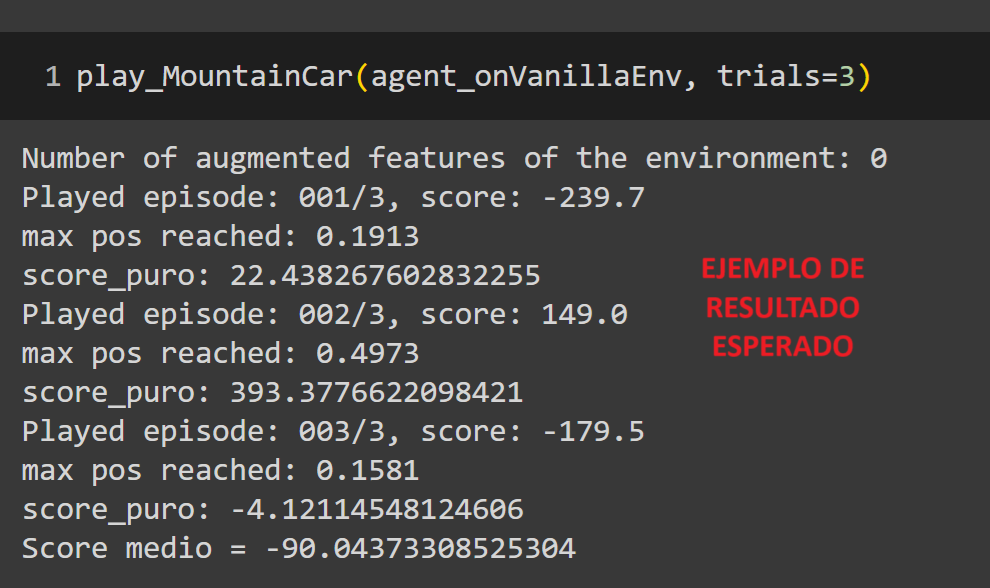

In [16]:
play_MountainCar(agent_onAugmentedEnv, trials=5)

Número de augmented features del entorno: 6
Car has reached the goal 😁
Played episode: 001/5, score: -249.6
max pos reached: 0.5391
score_puro: 69.99897481820487
Car has reached the goal 😁
Played episode: 002/5, score: -211.8
max pos reached: 0.5272
score_puro: 103.79980062430887
Car has reached the goal 😁
Played episode: 003/5, score: -235.3
max pos reached: 0.5104
score_puro: 43.24428204043606
Car has reached the goal 😁
Played episode: 004/5, score: -230.9
max pos reached: 0.5211
score_puro: 22.508063939225764
Car has reached the goal 😁
Played episode: 005/5, score: -218.4
max pos reached: 0.5366
score_puro: 20.72422822051479
Score medio = -229.19173313163583


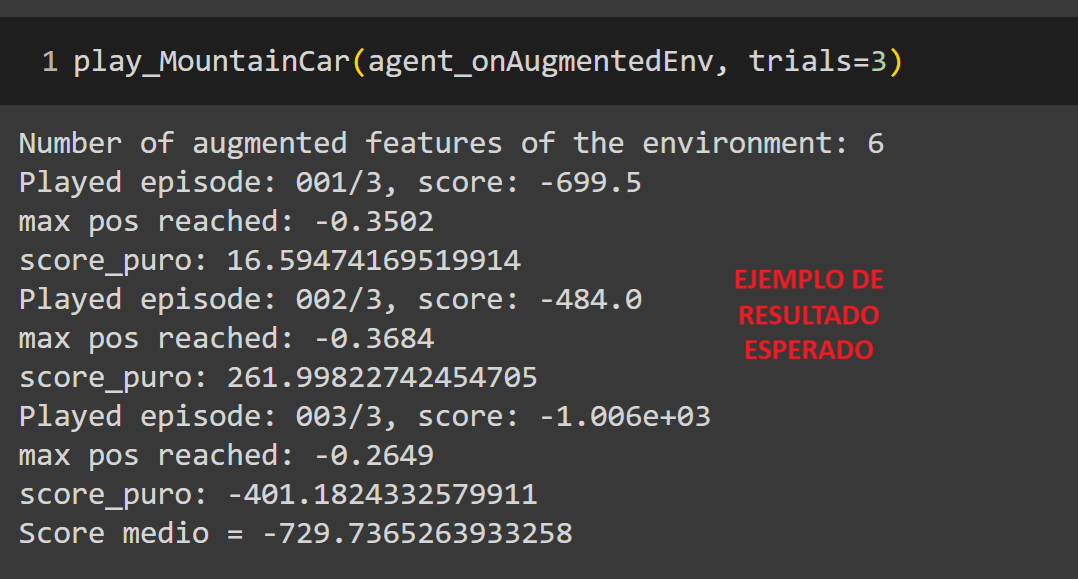

El objetivo del presente desafío es mostrar el pipeline para el entrenamiento e implementación de un modelo de DRL. No necesariamente sus modelos van a tener desempeños perfectos, pero se les está mostrando metodologías para mejorarlos, usando la teoría vista en clase, pero con una perspectiva adicional.

## Desafío de la semana: Entorno `MountainCar-v0` <font color='red'>(20 puntos en total)</font>

En esta sesión práctica, hemos visto:

- Dos estrategias de reward shaping (piecewise y bonificación adicional).
- Una estrategia de mejora de las características que recibe el agente para aprender.

***Ahora te toca a ti!***

Definir un modelo neuronal en la función `_build_model` y entrenar el agente DDQN. Si deseas, podrías utilizar DQN. Puedes modificar los siguientes hiperparámetros e ir viendo la combinación de valores que te conviene más: `memory`, `gamma`, `epsilon_decay`, `get_reward()` (se deja ya propuesta una función matemática con la que puedes terminar la implementación para calcular el reward), `batch_size` (el valor propuesto es 128), `EPISODES` (el valor propuesto es 150). Recuerda la teoría, por ejemplo, ¿`epsilon_decay` puede ser mayor a 1?


Es parte del desafío modificar adecuadamente los hiperparámetros de los agentes, así como las dos funciones previamente mencionadas, para mejorar su desempeño.

Asimismo, partiendo de las dos gráficas de los agentes individuales, deberá generar una gráfica unificadora para realizar la comparación de ambos agentes.

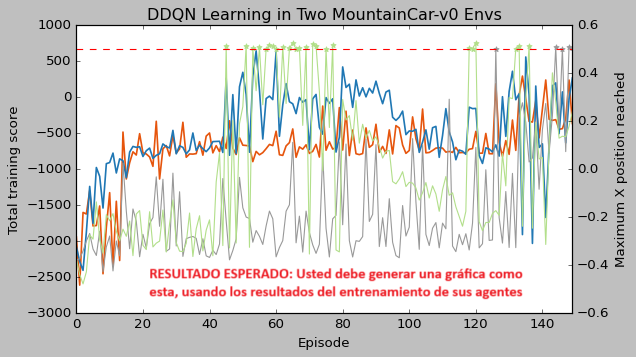

Para este desafío, debe subir un archivo comprimido que contenga su cuadernillo `ipynb`, así como sus archivos `agent.keras` y `agent_v2.keras` (relacionados al agente del entorno vanilla y al agente del entorno augmentado, respectivamente) <font color='red'>(0.5 puntos por cada agente)</font>.



Finalmente, deberá subir un video comentando sus resultados. Aquí debe explicar sus implementaciones: la forma de su función de reward, los estados augmentados que utilizó, verificar que no se brindó información de la acción como estado augmentado, y comentarios acerca de sus resultados obtenidos. Si llegó a realizar la parte del puntaje adicional, debe mostrar y explicar sus resultados en el video. Duración máxima del video: 5 minutos. En esta parte del desafío, se hará una valoración general de su trabajo

Nota importante: El presente desafío **debe** ser desarrollado en Google Colaboratory, pero la visualización del agente en el entorno es opcional y se realiza en GitPod (véase el inciso de puntaje bonus, líneas abajo).

GitPod:

Las instrucciones a seguir están en el archivo `playGymEnv.py`.

Comando para ejecutar: `python playGymEnv.py`.



Instrucciones:


```python
1) Subir dos archivos con las redes neuronales de sus agentes ya entrenados en su cuadernillo ipynb:
   `agent.keras`, y `agent_v2.keras`.
2) En el archivo `ddqn_sol.py`, debe completar la implementación de: `EstimadorEstadosInternos`, y `get_reward`. Seguir la teoría vista en clase. Deben ser
   las mismas implementaciones usadas en su cuadernillo ipynb.
3) En la línea de comandos, ejecutar: `python playGymEnv.py`.
4) NO debe modificar el presente archivo (`playGymEnv.py`).
# Tiene formato de código
```

### Rúbrica de puntajes

 1) Completar las celdas de código donde se hace la iteración `for e in range(1, EPISODES+1)`: <font color='red'>1 punto</font>


 2) Implementación de la clase `DDQNAgent`: <font color='red'>1 punto</font>


 3) Implementación de la función `get_reward`: <font color='red'>2 puntos</font>

 4) Implementación de la clase
`EstimadorEstadosInternos`: <font color='red'>2 puntos</font>

 5) Creación de la gráfica de comparación de los dos agentes: <font color='red'>2.5 puntos</font>

 6) Subir a PAIDEIA, junto con su archivo
`ipynb`, los archivos `agent.keras`, y `agent_v2.keras`: <font color='red'>1 punto</font>

 7) Exposición (Aquí se hace una valoración general de la calidad del trabajo realizado): <font color='red'>8 puntos</font>




La exposición tendrá una duración de 12 minutos como máximo. TODOS los participantes deben hablar en la presentación, pero no necesariamente el mismo tiempo cada uno.

### Puntaje restante: <font color='red'>2.5 puntos como máximo</font>

El resto del puntaje (2.5 puntos como máximo), según el desempeño de sus agentes ya entrenados llevados al entorno GitPod. Solamente debe modificar el archivo `ddqn_sol.py`; el archivo `playGymEnv.py` no debe ser alterado.


Los agentes diseñados para el entorno `MountainCar`, entrenados en cuadernillo ipynb y con los archivos de extensión `.keras` llevados a GitPod, luego de ejecutar en la terminal el comando `python playGymEnv`, de un total de 5 intentos:

- Por cada vez que alguno de sus agentes llega a alcanzar el bandería (i.e., su posición horizontal es mayor o igual a 0.5), <font color='red'>se otorgará MEDIO PUNTO</font>. Entonces, se puede obtener en esta parte <font color='red'>2.5 puntos como máximo</font>.

No olvidar mostrar estos resultados en su video.